In [1]:
### LSTM Forecasting ###
# Import Libraries
import math
import pandas_datareader as web

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('bmh')

import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get Data Frames from Yahoo! Finance
# yfinance is used to fetch data 
yf.pdr_override()
# input
symbol = 'AAPL'
start = '2012-01-01'
end = '2020-12-31'
# Read data 
df = yf.download(symbol,start,end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621428,14.732142,14.607142,14.686786,12.669562,302220800
2012-01-04,14.642858,14.810000,14.617143,14.765715,12.737655,260022000
2012-01-05,14.819643,14.948215,14.738214,14.929643,12.879071,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,13.013705,318292800
2012-01-09,15.196428,15.276786,15.048214,15.061786,12.993064,394024400


In [3]:
# Get number of trading days
df.shape

(2264, 6)

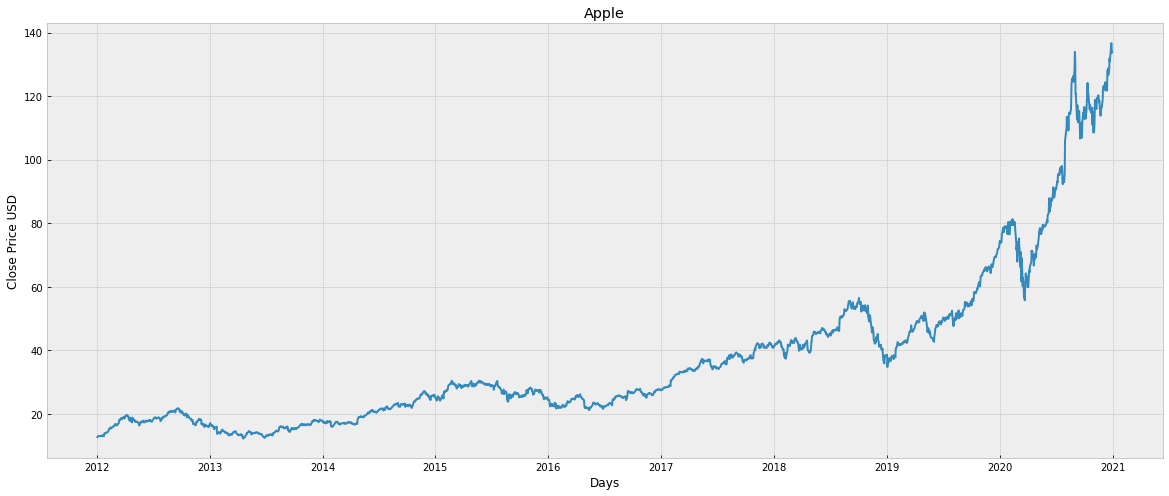

In [4]:
# Visualize Close Price data
plt.figure(figsize=(20,8))
plt.title('Apple')
plt.xlabel('Days')
plt.ylabel('Close Price USD')
plt.plot(df['Adj Close'])
plt.show()

In [5]:
# Create a new dataframe with only the 'Adj Close' column
data = df.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on (80% data traning 20% test)
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1812

In [6]:
# Scale the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.00369656],
       [0.00424357],
       [0.00537962],
       ...,
       [1.        ],
       [0.98537919],
       [0.97614085]])

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)

[array([0.00369656, 0.00424357, 0.00537962, 0.00646119, 0.00629537,
       0.00666911, 0.00649829, 0.00621123, 0.00582016, 0.00703046,
       0.00812191, 0.00778532, 0.00594142, 0.00770116, 0.00596866,
       0.01246555, 0.01196311, 0.01261899, 0.01403716, 0.01489598,
       0.01482419, 0.01455941, 0.015688  , 0.01674975, 0.01795263,
       0.01989548, 0.02397677, 0.02403865, 0.02631071, 0.02800856,
       0.02509053, 0.02621418, 0.02619188, 0.02934255, 0.02889459,
       0.02972374, 0.03121369, 0.03204281, 0.03443118, 0.03617109,
       0.03667351, 0.03684925, 0.03387433, 0.03315655, 0.03326297,
       0.03605976, 0.03684675, 0.0385372 , 0.04252194, 0.04783824,
       0.04684334, 0.0468458 , 0.05068947, 0.05189229, 0.05103597,
       0.05025382, 0.04943953, 0.05214474, 0.05400101, 0.05477818])]
[0.05285761585048235]


In [8]:
# Create the testing data set
# Create a new array containing scaled values from index 1549 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [9]:
# Convert the x_train and the y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1752, 60, 1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [12]:
# Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1752/1752 [==============================] - 42s 24ms/step - loss: 2.4072e-04


In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [17]:
# Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


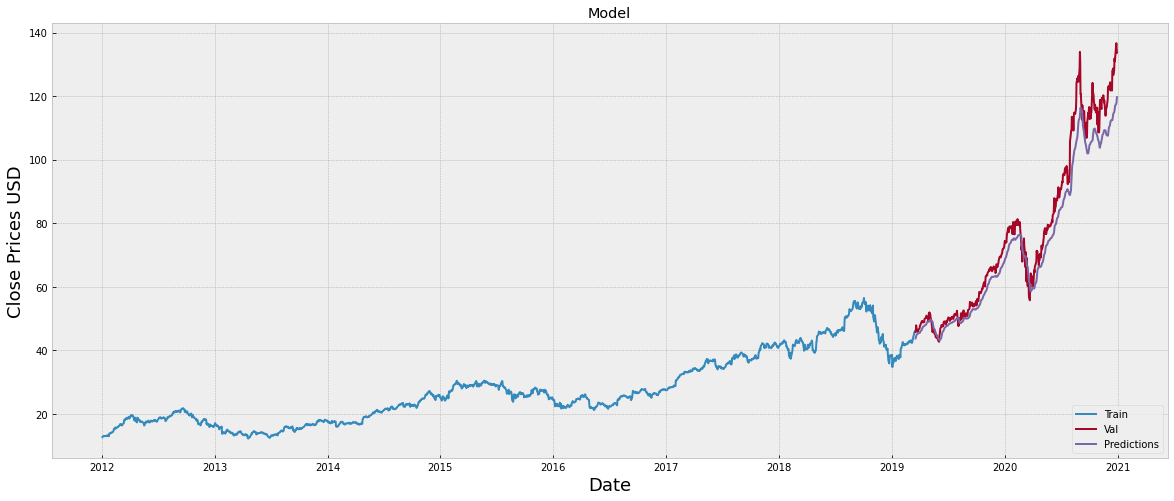

In [18]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize
plt.figure(figsize=(20,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Prices USD', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
# Get de root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

4.746814061055141

In [20]:
# Show de valid and predicted prices
valid

,Adj Close,Predictions
Date,,
2019-03-19,45.744209,43.713238
2019-03-20,46.143944,44.039371
2019-03-21,47.843437,44.338238
2019-03-22,46.852680,44.772324
2019-03-25,46.286179,45.112335
...,...,...
2020-12-23,130.960007,116.251762
2020-12-24,131.970001,116.966103
2020-12-28,136.690002,117.669647


In [22]:
### Get the quote - For predicting stock price in a selected date ###
# (This is used to prove the forecasting results)
# input
symbol = 'AAPL'
start = '2012-01-01'
end = '2019-12-31'
# Read data 
apple_quote = yf.download(symbol,start,end)
# Create a new dataframe
new_df = apple_quote.filter(['Adj Close'])
# Get the 60 day closing prices values and convert the data frame to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# Conver the X_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
[[67.92094]]


In [23]:
### Get the quote - For predicting stock price in a selected date ###
# input
symbol = 'AAPL'
start = '2019-12-18'
end = '2019-12-19'
# Read data 
apple_quote2 = yf.download(symbol,start,end)

print(apple_quote2['Adj Close'])


[*********************100%***********************]  1 of 1 completed
Date
2019-12-18    69.336212
Name: Adj Close, dtype: float64
